RealNVP implemented in `gluon.probability`, the implementation borrows largely from https://blog.evjang.com/2019/07/nf-jax.html

In [81]:
import mxnet as mx
from tqdm import tqdm
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
import numpy as onp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import celluloid
npx.set_np()
model_ctx = mx.gpu(0)
# model_ctx = mx.cpu()

In [82]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

## Dataset

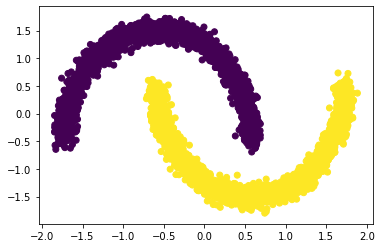

In [83]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 4000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, c = noisy_moons
X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], c=c)
X = np.array(X).astype('float32')

## Model definition

In [86]:
class RealNVP(mgp.TransformBlock):
    event_dim = 1
    
    def __init__(self, input_dim, flip=False, layer_dim=512, n_layer=2, act_type='relu', **kwargs):
        super(RealNVP, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.flip = flip
        self.net = nn.HybridSequential()
        for _ in range(n_layer):
            self.net.add(nn.Dense(layer_dim, activation=act_type))
        self.net.add(nn.Dense(input_dim))
    
    def _forward_compute(self, x):
        F = self.F
        d = self.input_dim // 2
        x1, x2 = x[:, :d], x[:, d:]
        if self.flip:
            x2, x1 = x1, x2
        shift, log_scale = F.np.split(self.net(x1), 2, 1)
        y2 = x2 * F.np.exp(log_scale) + shift
        if self.flip:
            x1, y2 = y2, x1
        y = F.np.concatenate([x1, y2], axis=-1)
        return y
    
    def _inverse_compute(self, y):
        F = self.F
        d = self.input_dim // 2
        y1, y2 = y[:, :d], y[:, d:]
        if self.flip:
            y1, y2 = y2, y1
        shift, log_scale = F.np.split(self.net(y1), 2, 1)
        x2 = (y2 - shift) * F.np.exp(-log_scale)
        if self.flip:
            y1, x2 = x2, y1
        x = F.np.concatenate([y1, x2], axis=-1)
        self._log_det_jacobian = log_scale.sum(-1)
        return x
    
    def log_det_jacobian(self, x, y):
        return self._log_det_jacobian

In [87]:
input_dim = 2
f1 = RealNVP(input_dim, True)
f2 = RealNVP(input_dim, False)
f1.initialize(mx.init.Xavier(), force_reinit=True, ctx=model_ctx)
f1.hybridize()
f2.initialize(mx.init.Xavier(), force_reinit=True, ctx=model_ctx)
f2.hybridize()
y = mgp.TransformedDistribution(mgp.Independent(mgp.Normal(np.zeros(input_dim, ctx=model_ctx), np.ones(input_dim, ctx=model_ctx)), 1), [f1, f2])

In [92]:
f1.collect_params()

{'net.0.weight': Parameter (shape=(512, 1), dtype=float32),
 'net.0.bias': Parameter (shape=(512,), dtype=float32),
 'net.1.weight': Parameter (shape=(512, 512), dtype=float32),
 'net.1.bias': Parameter (shape=(512,), dtype=float32),
 'net.2.weight': Parameter (shape=(2, 512), dtype=float32),
 'net.2.bias': Parameter (shape=(2,), dtype=float32)}

In [93]:
f2.collect_params()

{'net.0.weight': Parameter (shape=(512, 1), dtype=float32),
 'net.0.bias': Parameter (shape=(512,), dtype=float32),
 'net.1.weight': Parameter (shape=(512, 512), dtype=float32),
 'net.1.bias': Parameter (shape=(512,), dtype=float32),
 'net.2.weight': Parameter (shape=(2, 512), dtype=float32),
 'net.2.bias': Parameter (shape=(2,), dtype=float32)}

In [88]:
batch_size = 200
lr = 1e-3
data_iter = load_array((X,), batch_size)
trainer_f1 = gluon.Trainer(f1.collect_params(), 'adam', {'learning_rate': lr})
trainer_f2 = gluon.Trainer(f2.collect_params(), 'adam', {'learning_rate': lr})
num_epochs = 400

In [89]:
for epoch in tqdm(range(num_epochs)):
    for x in data_iter:
        with autograd.record():
            loss = -y.log_prob(x.as_in_ctx(model_ctx))
        loss.backward()
        trainer_f1.step(x.shape[0])
        trainer_f2.step(x.shape[0])

100%|██████████| 400/400 [00:59<00:00,  6.69it/s]


In [387]:
values = []
samples = np.random.normal(size=(1000, 2), ctx=model_ctx)
values.append(samples)
values.append(f1(samples))
values.append(f2(f1(samples)))

## Result

### Latent space

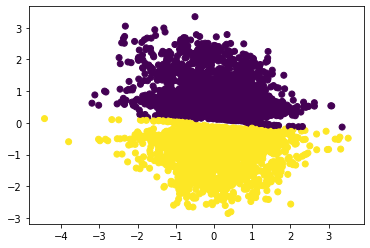

In [90]:
latent = f1.inv(f2.inv(X.as_in_ctx(model_ctx)))
plt.scatter(latent[:, 0], latent[:, 1], c=c)

### Reconstruction samples

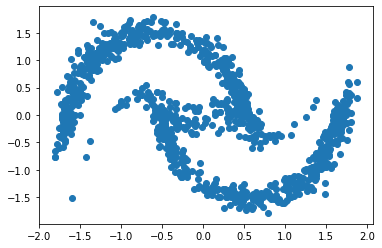

In [91]:
fit_samples = y.sample((1000, 2))
plt.scatter(fit_samples[:, 0], fit_samples[:, 1])

### Animation


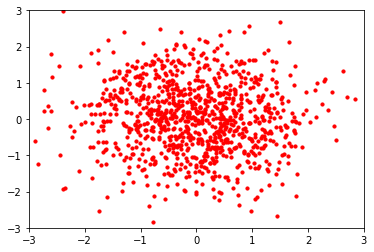

In [393]:
fig, ax = plt.subplots()
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [398]:
def animate(i):
    l = i//48
    t = (float(i%48))/48
    y = (1-t)*values[l] + t*values[l+1]
    paths.set_offsets(y)
    return (paths,)

anim = animation.FuncAnimation(fig, animate, frames=48*(len(values) - 1), interval=1, blit=False)

In [399]:
anim.save('anim_realNVP.gif', writer='imagemagick', fps=30)

In [400]:
Image(url='anim_realNVP.gif')